

# Line detection and matching with SOLD2: Self-supervised Occlusion-aware Line Description and Detection


In [ ]:
#Install kornia

!pip install kornia

In [64]:
#Import library

import torch
import torchvision
import kornia as k
import cv2
import kornia.feature as KF
import matplotlib.pyplot as plt

Load the images and convert into torch tensors.

In [ ]:
img_input1_path = '/kaggle/input/solarpaneltestimgs/0001.png'
img_input2_path = '/kaggle/input/solarpaneltestimgs/0002.jpeg' # specify the image paths

In [65]:
img_input1= cv2.imread(img_input1_path,cv2.IMREAD_COLOR)
img_input2= cv2.imread(img_input2_path,cv2.IMREAD_COLOR)

In [66]:
img_input1 = k.utils.image_to_tensor(img_input1)  # CxHxWx
img_input1 = img_input1[None,...].float() / 255.
img_input2 = k.utils.image_to_tensor(img_input2)  # CxHxWx
img_input2 = img_input2[None,...].float() / 255.

In [67]:
def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np: np.ndarray = k.utils.tensor_to_image(out)
    plt.figure(figsize=(10,10))
    plt.imshow(out_np)
    plt.axis('off')
    plt.show()

In [ ]:
imshow(img_input2)

In [68]:
img1_rgb = k.color.bgr_to_rgb(img_input1)
img1_gray = k.color.rgb_to_grayscale(img1_rgb)
img2_rgb = k.color.bgr_to_rgb(img_input2)
img2_gray = k.color.rgb_to_grayscale(img2_rgb)

Prepare the data for the model, which is expected a batch of images in gray scale (shape: (Batch size, 1, Height, Width)).

SOLD2 is tuned for images in the range 400~800px when using config = None but we will specify parameters.


In [ ]:
imshow(img2_gray) #making sure image is loaded correctly

In [70]:
#torch_img1_gray.shape, torch_img2_gray.shape
img1_gray.shape, img2_gray.shape

(torch.Size([1, 1, 512, 640]), torch.Size([1, 1, 512, 640]))

In [71]:
# then, stack the images to create/simulate a batch
imgs = torch.cat([img1_gray, img2_gray], dim=0)
imgs.shape

torch.Size([2, 1, 512, 640])

## Performs line detection and matching

Load the sold2 model with `pre-trained=True`, which will download and set pre-trained weights to the model.

In [79]:
config = {
    'backbone_cfg': {'input_channel': 1, 'depth': 4, 'num_stacks': 2, 'num_blocks': 1, 'num_classes': 5},
    'use_descriptor': True,
    'grid_size': 8,
    'keep_border_valid': True,
    'detection_thresh': 0.0153866,  # = 1/65: threshold of junction detection
    'max_num_junctions': 550,  # maximum number of junctions per image
    'line_detector_cfg': {
        'detect_thresh': 0.5,
        'num_samples': 64,
        'inlier_thresh': 0.99,
        'use_candidate_suppression': True,
        'nms_dist_tolerance': 2.0,
        'use_heatmap_refinement': True,
        'heatmap_refine_cfg': {
            'mode': "local",
            'ratio': 0.2,
            'valid_thresh': 0.002,
            'num_blocks': 20,
            'overlap_ratio': 0.5,
        },
        'use_junction_refinement': True,
        'junction_refine_cfg': {'num_perturbs': 9, 'perturb_interval': 0.25},
    },
    'line_matcher_cfg': {
        'cross_check': True,
        'num_samples': 5,
        'min_dist_pts': 5,
        'top_k_candidates': 10,
        'grid_size': 4,
    },
}

In [80]:
%%capture
sold2 = KF.SOLD2(pretrained=True, config=config)

In [ ]:
!cat /opt/conda/lib/python3.10/site-packages/kornia/feature/sold2/sold2.py

In [ ]:
# %%capture
# sold2 = KF.SOLD2(pretrained=True, config=None)

In [ ]:
KF.SOLD2??


### Perform the model prediction

In [81]:
%%capture
with torch.inference_mode():
    outputs = sold2(imgs)

In [ ]:
line_seg1 = outputs["line_segments"][0]
len(line_seg1)
#line_seg1[0,1,1],line_seg1[0,0,1],line_seg1[0,1,0],line_seg1[0,0,0]
#line_seg1



Organize the outputs for demo.

**Attention:** The detected line segments is in *ij coordinates convention*.

In [ ]:
outputs.keys()

In [82]:
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
# desc1 = outputs["dense_desc"][0]
# desc2 = outputs["dense_desc"][1]

In [ ]:
# with torch.inference_mode():
#     matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])

In [ ]:
# valid_matches = matches != -1
# match_indices = matches[valid_matches]

# matched_lines1 = line_seg1[valid_matches]
# matched_lines2 = line_seg2[match_indices]

## Plot lines detected 

Plot functions adapted from [original code](https://github.com/cvg/SOLD2/blob/ddd36788c112136be2975ee29b096df979571bb2/sold2/misc/visualize_util.py).

In [83]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)
    


def plot_lines(lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)):
    """Plot lines and endpoints for existing images.
    Args:
        
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)

            
    fig.savefig('full_figure.png')              

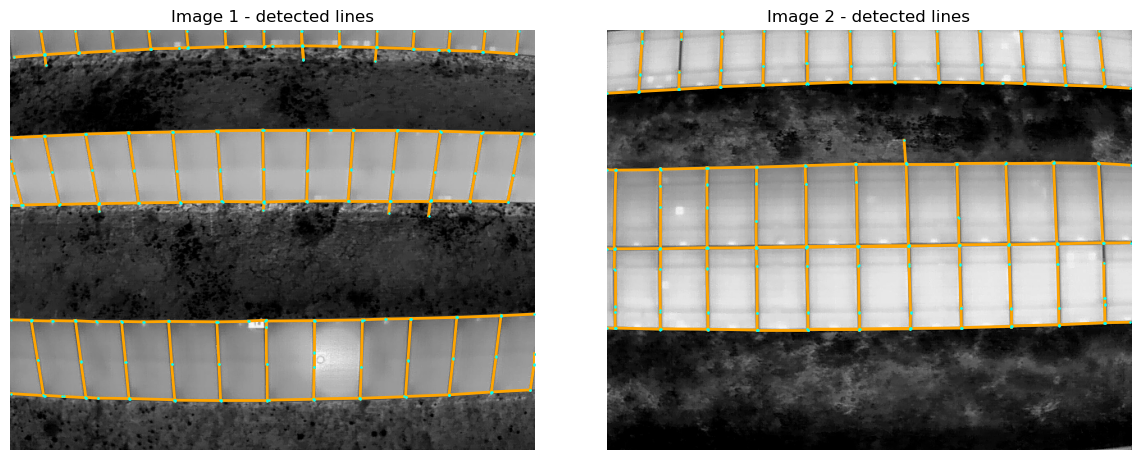

In [84]:
imgs_to_plot = [k.tensor_to_image(img_input1), k.tensor_to_image(img_input2)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

In [ ]:
# type(img_input1)
plot_images(k.tensor_to_image(img_input1))

In [ ]:
# plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
# plot_color_line_matches([matched_lines1, matched_lines2], lw=2)